<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Simple-DeepDream" data-toc-modified-id="Simple-DeepDream-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simple DeepDream</a></span><ul class="toc-item"><li><span><a href="#Download" data-toc-modified-id="Download-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Download</a></span></li><li><span><a href="#Deprocess" data-toc-modified-id="Deprocess-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Deprocess</a></span></li><li><span><a href="#Show" data-toc-modified-id="Show-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Show</a></span></li><li><span><a href="#Pre-trained" data-toc-modified-id="Pre-trained-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Pre trained</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#calc_loss" data-toc-modified-id="calc_loss-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>calc_loss</a></span></li><li><span><a href="#main-class-simple-deepdream" data-toc-modified-id="main-class-simple-deepdream-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>main class simple deepdream</a></span><ul class="toc-item"><li><span><a href="#call" data-toc-modified-id="call-1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span><strong>call</strong></a></span></li></ul></li><li><span><a href="#run_deep_dream_simple" data-toc-modified-id="run_deep_dream_simple-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>run_deep_dream_simple</a></span></li></ul></li><li><span><a href="#Deep-Dream-using-octaves-and-scalability" data-toc-modified-id="Deep-Dream-using-octaves-and-scalability-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Deep Dream using octaves and scalability</a></span><ul class="toc-item"><li><span><a href="#random_roll" data-toc-modified-id="random_roll-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>random_roll</a></span></li><li><span><a href="#TiledGradients" data-toc-modified-id="TiledGradients-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>TiledGradients</a></span></li><li><span><a href="#run_deep_dream_with_octaves" data-toc-modified-id="run_deep_dream_with_octaves-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>run_deep_dream_with_octaves</a></span></li></ul></li></ul></div>

# Simple DeepDream

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [2]:
import tensorflow as tf

In [3]:
import IPython.display as display
import matplotlib as mpl
import numpy as np
import PIL.Image
from tensorflow.keras.preprocessing import image

- IPython display will allow us to render images directly in this notebook from PIL

In [4]:
url = 'https://nicolekessler.files.wordpress.com/2013/04/hellish_demons.jpg?w=1024'

## Download
- We first download the image
- Resize it for faster computation

In [20]:
def download(url, max_dim=None):
    name = "demons.jpg"
    image_path = tf.keras.utils.get_file(name, origin=url)
    img = PIL.Image.open(image_path)
    if max_dim:
        img.thumbnail((max_dim, max_dim))
    return np.array(img)

## Deprocess
- This is a process called normalization
- tf.cast is used to convert the tensor into a 8 bit integer value representation


In [21]:
def deprocess(img):
    img = 255 * (img + 1.0) / 2.0
    return tf.cast(img, tf.uint8)


## Show

- just a wrapper to convert the tensor into an array and display

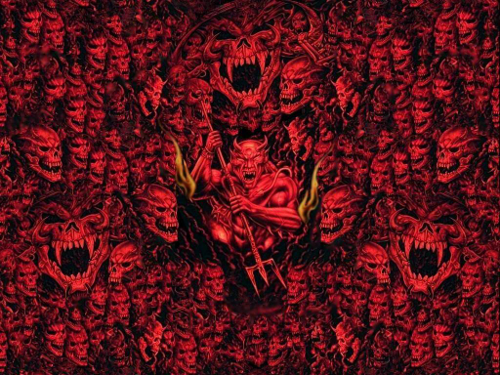

In [6]:
def show(img):
    display.display(PIL.Image.fromarray(np.array(img)))


original_img = download(url, max_dim=500)
show(original_img)

## Pre trained

- We use Inception Net v3 which is a pretrained network that already has some idea of the world. 
- We use imagenet weights which basically allows us to use transfer learning on the network
- Instead of training from scratch we can just cherry pick layers and use our neural network on it

In [7]:
base_model = tf.keras.applications.InceptionV3(include_top=False,
                                               weights='imagenet')

In [8]:
names = ['mixed3', 'mixed5']
layers = [base_model.get_layer(name).output for name in names]

dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

## Model

- We now choose two layers mixed3 and mixed5 from the inception pretrained network. The layers list will allow us to use these names and choose them from the model
- We then create a model with the base model (Inception) as input and the layers as output

In [9]:
def calc_loss(img, model):
    img_batch = tf.expand_dims(img, axis=0)
    layer_activations = model(img_batch)

    losses = []
    for act in layer_activations:
        loss = tf.math.reduce_mean(act)
        losses.append(loss)

    return tf.reduce_sum(losses)

## calc_loss

- We take the image and the model as inputs
- expand dims basically adds an extra dimension to our input along the x axis to make it work with inception
- for every activation in our layers, we calculate the loss and append it to a list
- reduce_mean() and reduce_sum() are approximately the mean and sum equivalent for tensors instead of just plain arrays
- Thus the sum is the total loss we get

In [10]:
class DeepDream(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=(
        tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),
    ))
    def __call__(self, img, steps, step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = calc_loss(img, self.model)

            gradients = tape.gradient(loss, img)

            gradients /= tf.math.reduce_std(gradients) + 1e-8

            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)

        return loss, img

In [11]:
deepdream = DeepDream(dream_model)

## main class simple deepdream

- the @tf.function allows the function to be precompiled. Since it is compiled, it runs faster
- tensorspec basically allows us to pre define the shapes of specific arrays as we are pre compiling it
### __call__
- here we are trying to find the gradients of the image
- this method is called gradient ascent. This adds the gradients found in every layer to the image and thus increases the activations at that point as well which is what we want
- GradientTape allows us to keep a sort of history of all the gradients and allows us to use it to calculate loss directly from the history
- After we get the gradients, we normalize them
- img = img + gradients * step_size is the main ascent function which maximizes the loss
- the clip value function here is used to scale all numbers to -1 or 1. Any values less than -1 is set to 1 and greater than 1 is set to 1. (You can say its another form of normalization)

In [12]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):

    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img, run_steps, tf.constant(step_size))

        display.clear_output(wait=True)
        show(deprocess(img))
        print("Step {}, loss {}".format(step, loss))

    result = deprocess(img)
    display.clear_output(wait=True)
    show(result)

    return result

## run_deep_dream_simple
- We have to first pre process the image to be able to work with the pre processed network. (Basically converts it into the format inception was trained)
- We then convert it into a tensor and split the execution into parts
- We simply use the deepdream function to calculate the losses 
- We use the deprocess function to convert it back into an image from a tensor
- clear_output is just a function to make sure the notebook doesnt get flooded with outputs and only the latest output is kept

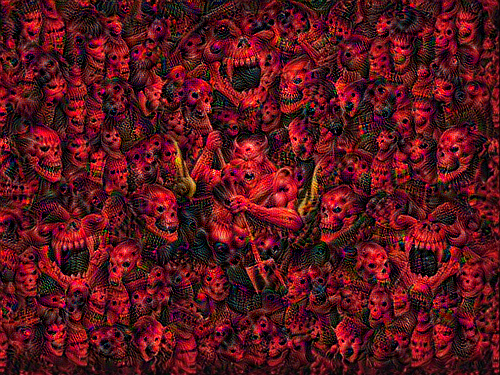

In [13]:
dream_img = run_deep_dream_simple(img=original_img, steps=100, step_size=0.01)

# Deep Dream using octaves and scalability

- An octave is basically the size of the image
- In this case we notice that the image above basically has the same patterns throughout so we try to resize the image to different scales and apply the gradient ascent algo to each of these parts

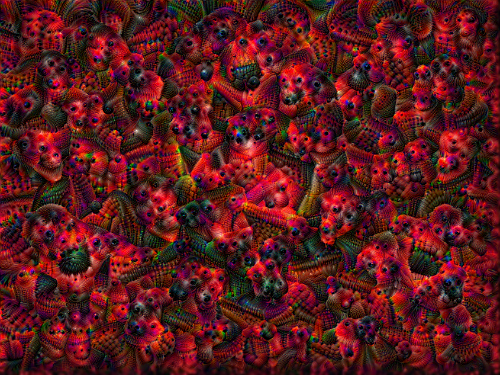

13.866624116897583

In [14]:
import time

start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
    new_shape = tf.cast(float_base_shape * (OCTAVE_SCALE**n), tf.int32)

    img = tf.image.resize(img, new_shape).numpy()

    img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img / 255.0, dtype=tf.uint8)
show(img)

end = time.time()
end - start

## random_roll
- this function allows us to generate random crops and shifts from the image we took
- this is done to better allow the model to learn from the image

In [15]:
def random_roll(img, maxroll):
    shift = tf.random.uniform(shape=[2],
                              minval=-maxroll,
                              maxval=maxroll,
                              dtype=tf.int32)
    shift_down, shift_right = shift[0], shift[1]
    img_rolled = tf.roll(tf.roll(img, shift_right, axis=1), shift_down, axis=0)
    return shift_down, shift_right, img_rolled

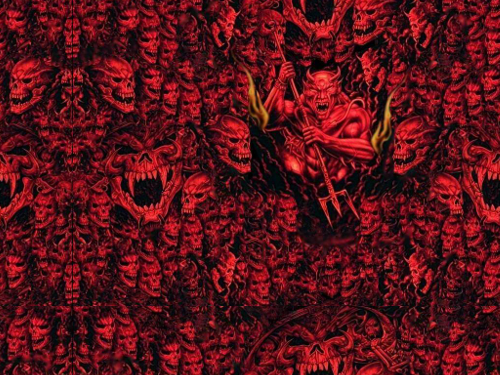

In [16]:
shift_down, shift_right, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

## TiledGradients
- This class basically applies what has been mentioned so far.
- The image is split into tiles
- Gradient ascent is applied to every part of this image
- The gradients are stored in the GradientTape
- The image is combined and learned from

In [17]:
class TiledGradients(tf.Module):
    def __init__(self, model):
        self.model = model

    @tf.function(input_signature=(
        tf.TensorSpec(shape=[None, None, 3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
    ))
    def __call__(self, img, tile_size=512):
        shift_down, shift_right, img_rolled = random_roll(img, tile_size)

        gradients = tf.zeros_like(img_rolled)
        xs = tf.range(0, img_rolled.shape[0], tile_size)[:-1]
        if not tf.cast(len(xs), bool):
            xs = tf.constant([0])
        ys = tf.range(0, img_rolled.shape[1], tile_size)[:-1]
        if not tf.cast(len(ys), bool):
            ys = tf.constant([0])

        for x in xs:
            for y in ys:
                with tf.GradientTape() as tape:
                    tape.watch(img_rolled)

                    img_tile = img_rolled[x:x + tile_size, y:y + tile_size]
                    loss = calc_loss(img_tile, self.model)

                gradients = gradients + tape.gradient(loss, img_rolled)

        gradients = tf.roll(tf.roll(gradients, -shift_right, axis=1),
                            -shift_down,
                            axis=0)

        gradients /= tf.math.reduce_std(gradients) + 1e-8

        return gradients

In [18]:
get_tiled_gradients = TiledGradients(dream_model)

## run_deep_dream_with_octaves
- Preprocess the image to fit inception standards
- Convert to tensor
- Split into octaves and train for multiple scales and gradients
- Deprocess and show the image

In [19]:
def run_deep_dream_with_octaves(img,
                                steps_per_octave=200,
                                step_size=0.01,
                                octaves=range(-2, 3),
                                octave_scale=1.3):
    base_shape = tf.shape(img)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)

    initial_shape = img.shape[:-1]
    img = tf.image.resize(img, initial_shape)
    for octave in octaves:
        new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]),
                           tf.float32) * (octave_scale**octave)
        img = tf.image.resize(img, tf.cast(new_size, tf.int32))

        for step in range(steps_per_octave):
            gradients = get_tiled_gradients(img)
            img = img + gradients * step_size
            img = tf.clip_by_value(img, -1, 1)

            if step % 10 == 0:
                display.clear_output(wait=True)
                show(deprocess(img))
                print("Octave {}, Step {}".format(octave, step))

    result = deprocess(img)
    return result

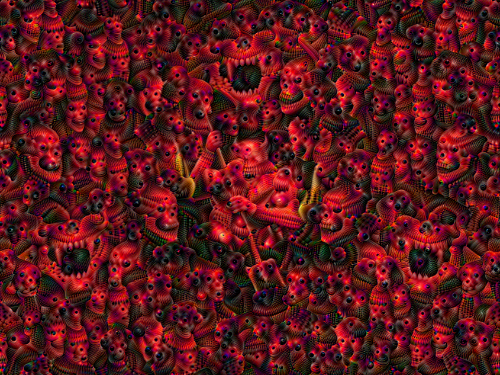

In [80]:
img = run_deep_dream_with_octaves(img=original_img,
                                  step_size=0.01,
                                  steps_per_octave=100,
                                  octaves=[1, 2])

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img / 255.0, dtype=tf.uint8)
show(img)